In [1]:
!pip install openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.0/250.0 kB 18.6 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import math
import openpyxl
import matplotlib.pyplot as plt

In [3]:
file_path = "data/ESG_raw_data_07_02.xlsx"
file_sect = "data/secteurs.csv"
corresp_secteurs = pd.read_csv(file_sect, sep=";")
data = pd.read_excel(file_path)
data = data.join(corresp_secteurs.set_index('primary_industry'), on = "primary_industry")

In [4]:
secteurs = pd.unique(data["secteur"])

In [5]:
variables_env = ["scope_1", "scope_2", "scope_3", "waste_production", "waste_recycling", 
                 "water_consumption", "water_withdrawal", "energy_consumption"]

for v in variables_env :
    data[v] = data[v]/data["employees"]

## Scope 1

On va analyser l'hétérogénéité intra-sectorielles pour le scope 1.

In [63]:
def visualisation(scope, sec, per) :
    df = data.loc[data["secteur"] == sec]
    df = df.groupby('company_id')[scope].mean().reset_index()
    mean = df[scope].mean()
    df = df[df[scope] <= mean*(1 + per)]
    df = df[df[scope] >= mean*(1 - per)]
    var = df[scope].var()
    new_mean = df[scope].mean()
    df[scope] = (df[scope]-new_mean)/np.sqrt(var)
    return df

Text(0.5, 1.0, 'Scope 1 Information Technology')

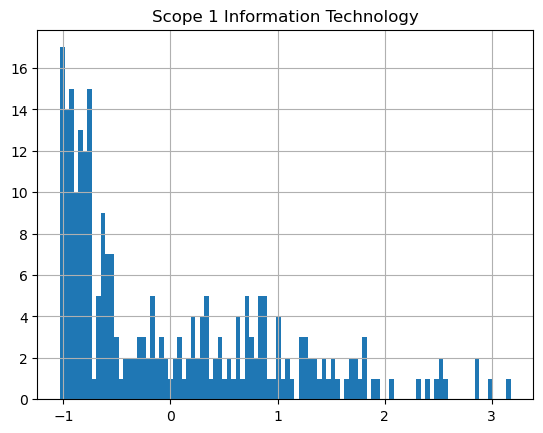

In [64]:
visualisation("scope_1", secteurs[0], 0.9).hist(column = "scope_1", bins = 100)
plt.title("Scope 1 " + secteurs[0])

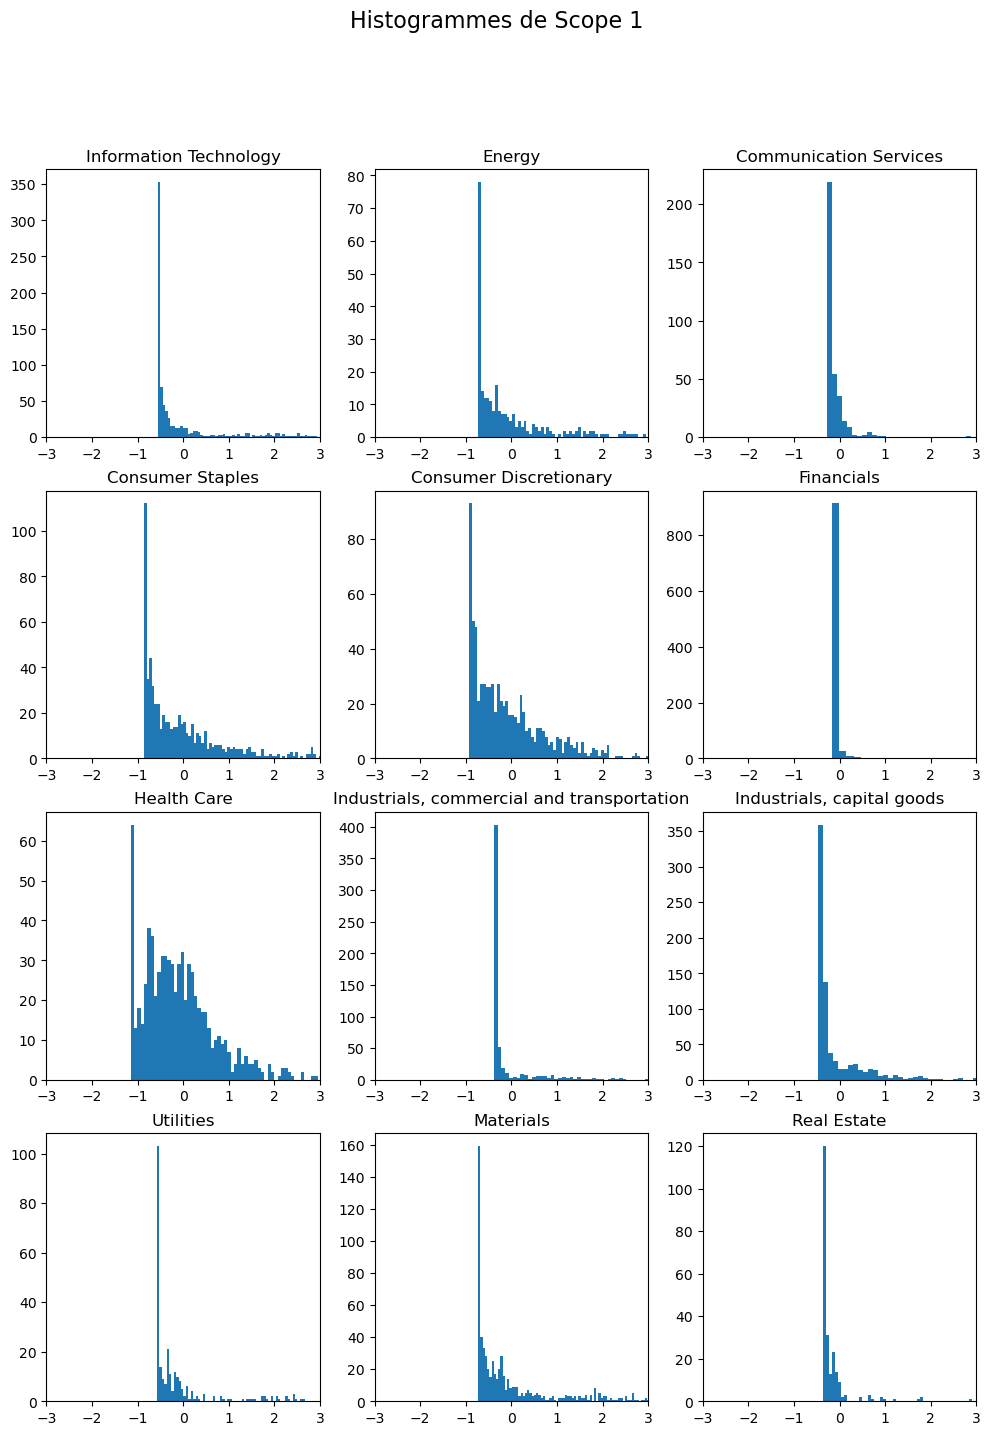

In [68]:
plt.figure(figsize=(12, 16))

i = 1
for s in secteurs :
    df = visualisation("scope_1", s, 1)
    plt.subplot(4,3,i)
    plt.hist(df["scope_1"], bins = 100)
    plt.title(s)
    plt.xlim([-3, 3])
    i += 1

plt.suptitle("Histogrammes de Scope 1", fontsize=16)
plt.show()